## Catalogue


1.   Build a RNN LSTM classifier for Kaggle competition
2.   Explore with or without padding and LSTM layer
3.   Accuracy and cross validation accuracy visualization
4.   Predict Kaggle competition test dataset
5.   Predict my Reddit dataset for another task COVID19 business problem

** Kaggle ID: Jamin

**Please note that: I use RNN LSTM in this Kaggle's competition task, and NB classifier in my business problem**

In [ ]:
# import related libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras import layers
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# google colab file system
from google.colab import files
import io
uploaded = files.upload()

Saving MSA_original.csv to MSA_original.csv


In [ ]:
#load the file
data = pd.read_csv('MSA_original.csv')

In [ ]:
#select the right columns
data = data[['text','sentiment']]
data.head() 

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


### data preprocessing

In [ ]:
# convert the text data
data.text=data.text.astype(str)

In [ ]:
from nltk.corpus import stopwords
stopwords=stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
#convert all to lower case
data['text'] = data['text'].apply(lambda x: x.lower())
#remove all special characters, punctuation and spaces
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
#remove links
data['text'] = data['text'].apply(lambda x: re.sub(r'\(?http\S+', '', x))
#remove stop word
data['text'] = data['text'].apply(lambda x: ' '.join(
    [word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))
#Lemmatization 
data['text'] = data['text'].apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]) )

print(data[ data['sentiment'] == 'neutral'].size)
print(data[ data['sentiment'] == 'positive'].size)
print(data[ data['sentiment'] == 'negative'].size)

22236
17164
15562


Vectorize text, by turning each text into either a sequence of integers or into a vector.
* Limit the data set to the top 5,000 words.

In [ ]:
max_fatures = 5000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)


Truncate and pad the text so that they are all in the same length.

In [ ]:
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

### Modeling
* The first embedded layer uses 128 length vectors to represent each word.
* SpatialDropout1D performs variational dropout in NLP models.
* The next layer is the LSTM layer with 100 memory units.
* The output layer must create 3 output values(negative, neutral, positive). one for each class.
* Activation function is softmax for multi-class classification.
Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [ ]:
#this is fixed
embed_dim = 128
#LSTM layer can be changed
lstm_out = 100

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 26, 128)           640000    
_________________________________________________________________
spatial_dropout1d_18 (Spatia (None, 26, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_38 (Dense)             (None, 3)                 303       
Total params: 731,903
Trainable params: 731,903
Non-trainable params: 0
_________________________________________________________________
None


Train test split

In [ ]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(24732, 26) (24732, 3)
(2749, 26) (2749, 3)


In [ ]:
batch_size = 64
history = model.fit(X_train, Y_train, validation_split=0.2, epochs = 3, batch_size=batch_size, verbose = 2)

Epoch 1/3
310/310 - 29s - loss: 0.8504 - accuracy: 0.6072 - val_loss: 0.7398 - val_accuracy: 0.6899
Epoch 2/3
310/310 - 28s - loss: 0.6452 - accuracy: 0.7389 - val_loss: 0.7178 - val_accuracy: 0.7002
Epoch 3/3
310/310 - 28s - loss: 0.5717 - accuracy: 0.7736 - val_loss: 0.7266 - val_accuracy: 0.6978


#### Loss and Accuracy

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

86/86 [==============================] - 1s 10ms/step - loss: 0.7409 - accuracy: 0.6904
Test set
  Loss: 0.741
  Accuracy: 0.690


Accuracy and cross validation accuracy visualization

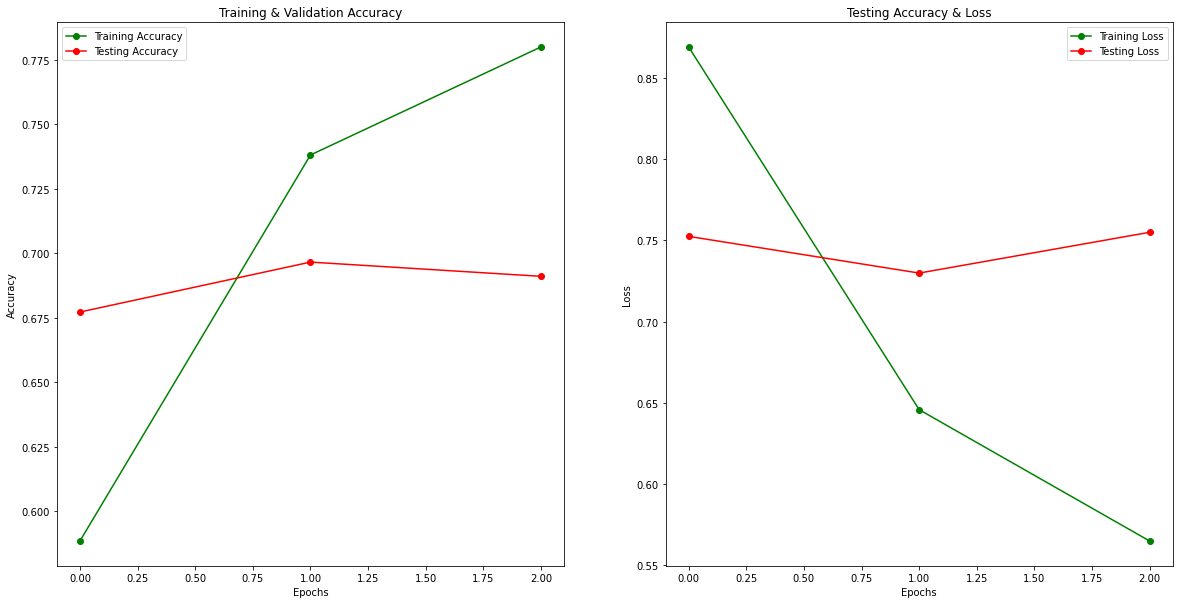

In [ ]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_accuracy , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

It looks like the validation accuracy starts to go down after the first epoch.it's possible that yit learn most of the important stuff during the first epoch. When the data shows again, the model will start overfitting.  

### Try Loss and accuracy without and with stacking of LSTM layers

Instead of using LSTM, I use SimpleRNN. The loss and accuracy is worse than the LSTM model.

In [ ]:
import tensorflow as tf
#this is fixed
embed_dim = 128
#LSTM layer can be changed
lstm_out = 100

model2 = Sequential()
model2.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model2.add(SpatialDropout1D(0.2))
model2.add(layers.SimpleRNN(128))
#model2.add(layers.Dense(10))
#model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)) # I comment the LSTM layer
model2.add(Dense(3,activation='softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model2.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 26, 128)           640000    
_________________________________________________________________
spatial_dropout1d_17 (Spatia (None, 26, 128)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               32896     
_________________________________________________________________
dense_37 (Dense)             (None, 3)                 387       
Total params: 673,283
Trainable params: 673,283
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 64
history2 = model2.fit(X_train, Y_train, validation_split=0.33, epochs = 3, batch_size=batch_size, verbose = 2)

Epoch 1/3
259/259 - 7s - loss: 0.9246 - accuracy: 0.5540 - val_loss: 0.7909 - val_accuracy: 0.6618
Epoch 2/3
259/259 - 7s - loss: 0.6069 - accuracy: 0.7616 - val_loss: 0.8123 - val_accuracy: 0.6638
Epoch 3/3
259/259 - 7s - loss: 0.3788 - accuracy: 0.8618 - val_loss: 0.9895 - val_accuracy: 0.6313


In [ ]:
accr = model2.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

86/86 [==============================] - 0s 4ms/step - loss: 1.0116 - accuracy: 0.6235
Test set
  Loss: 1.012
  Accuracy: 0.623


### Without padding

Without padding, I convert the tokenized word to an array and use masker layer instead. The loss and accuracy is similar with padding. 

In [ ]:
X2 = tokenizer.texts_to_sequences(data['text'].values)
X2 = np.array(X2)

In [ ]:
#this is fixed
embed_dim = 128
#LSTM layer can be changed
lstm_out = 100

model3 = Sequential()
model3.add(Embedding(max_fatures, embed_dim, mask_zero = True))
model3.add(SpatialDropout1D(0.2))
model3.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(3,activation='softmax'))
model3.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model3.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 128)         640000    
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, None, 128)         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_30 (Dense)             (None, 3)                 303       
Total params: 731,903
Trainable params: 731,903
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 64
history = model3.fit(X_train, Y_train, validation_split=0.33, epochs = 3, batch_size=batch_size, verbose = 2)

Epoch 1/3
259/259 - 27s - loss: 0.8680 - accuracy: 0.6129 - val_loss: 0.7730 - val_accuracy: 0.6750
Epoch 2/3
259/259 - 27s - loss: 0.6588 - accuracy: 0.7384 - val_loss: 0.7597 - val_accuracy: 0.6926
Epoch 3/3
259/259 - 27s - loss: 0.5764 - accuracy: 0.7800 - val_loss: 0.7765 - val_accuracy: 0.6851


In [ ]:
accr = model3.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

86/86 [==============================] - 1s 11ms/step - loss: 0.7948 - accuracy: 0.6715
Test set
  Loss: 0.795
  Accuracy: 0.672


### Prediction the Kaggle Competition test set

In [ ]:
# google colab file system
from google.colab import files
import io
uploaded = files.upload()

Saving test (1).csv to test (1).csv


In [ ]:
#load the data
data2 = pd.read_csv('test (1).csv')

In [ ]:
# select the right column
test_word = data2['text']

In [ ]:
#all convert to str
test_word=test_word.astype(str)

In [ ]:
# bunch of text preprocessing
from nltk.corpus import stopwords
stoplist = set(stopwords.words("english"))
test_word = test_word.apply(lambda x: x.lower())
test_word = test_word.apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
test_word = test_word.apply(lambda x: re.sub(r'\(?http\S+', '', x))
test_word = test_word.apply(lambda x: ' '.join(
    [word for word in nltk.word_tokenize(x) if word.lower() not in stoplist]))
test_word = test_word.apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]) )


In [ ]:
#Fit the model
txt = test_word
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=32)
pred = model.predict(padded)
labels = [ 'negative','neutral','positive']

#create a list to put all the labels
result = []
for i in range(0,len(test_word)):
  plus = labels[np.argmax(pred[i])]
  result.append(plus)
print(result)


['neutral', 'positive', 'negative', 'positive', 'neutral', 'positive', 'negative', 'positive', 'positive', 'neutral', 'negative', 'neutral', 'neutral', 'negative', 'negative', 'negative', 'negative', 'neutral', 'positive', 'positive', 'negative', 'negative', 'negative', 'neutral', 'negative', 'positive', 'negative', 'neutral', 'neutral', 'negative', 'neutral', 'neutral', 'negative', 'neutral', 'neutral', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'neutral', 'neutral', 'neutral', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'neutral', 'neutral', 'neutral', 'positive', 'neutral', 'positive', 'neutral', 'neutral', 'neutral', 'positive', 'neutral', 'neutral', 'neutral', 'negative', 'positive', 'neutral', 'positive', 'neutral', 'negative', 'neutral', 'positive', 'negative', 'negative', 'neutral', 'neutral', 'negative', 'neutral', 'neutral', 'positive', 'neutral', 'positive', 'neutral', 'neutral', 'positive', 'positive', 'negative', 'ne

In [ ]:
#get the sentiment and concat with textID for final submission
test_word2 = pd.Series(result, name='sentiment')

In [ ]:
df_final = pd.concat([data2['textID'], test_word2] , axis=1)

In [ ]:
df_final.head()

,textID,sentiment
0,f87dea47db,neutral
1,96d74cb729,positive
2,eee518ae67,negative
3,01082688c6,positive
4,33987a8ee5,neutral


In [ ]:
df_final.to_csv('MSA_Jamin7.csv', index=False)

### Use the same method to label all my data from Reddit

In [ ]:
# google colab file system
from google.colab import files
import io
uploaded = files.upload()

Saving reddit_label.csv to reddit_label.csv


This is a clean dataset which I have already preprocessed and labeled with textblob, and I will create a new column with my LSTM trainning model 

In [ ]:
#load the data
reddit = pd.read_csv('reddit_label.csv')

In [ ]:
# select the right column
reddit_word = reddit['text']

In [ ]:
#Fit the model, change the maxlen to 250
txt = reddit_word
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=250)
pred = model.predict(padded)
labels = [ 'negative','neutral','positive']

#create a list to put all the labels
result = []
for i in range(0,len(txt)):
  plus = labels[np.argmax(pred[i])]
  result.append(plus)
print(result)


['neutral', 'neutral', 'negative', 'negative', 'negative', 'negative', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'negative', 'neutral', 'negative', 'neutral', 'negative', 'neutral', 'positive', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'negative', 'negative', 'neutral', 'neutral', 'neutral', 'negative', 'negative', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'positive', 'neutral', 'positive', 'neutral', 'neutral', 'neutral', 'negative', 'neutral', 'positive', 'negative', 'neutral', 'positive', 'neutral', 'neutral', 'neutral', 'negative', 'negative', 'neutral', 'negative', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'positive', 'negative', 'positive', 'neutral', 'neutral', 'neutral', 'neutral', 'positive', 'neutral', 'neutral', 'neutral', 'positive', 'neutral', 'neutral', 'neutral', 'neutral', 'positive', 'positive', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'ne

In [ ]:
#get the sentiment and concat with textID for final submission
reddit_word2 = pd.Series(result, name='my_sentiment')

In [ ]:
#concat my training sentiment with original dataset
reddit_final = pd.concat([reddit, reddit_word2] , axis=1)

In [ ]:
reddit_final.tail()

,Unnamed: 0,text,sentiment,my_sentiment
32644,32644,course meant young people first line vaccine s...,positive,positive
32645,32645,right death bigger concern side effect,positive,positive
32646,32646,fair enough sure source youre listening widely...,positive,neutral
32647,32647,saying young people first outside reddit,positive,neutral
32648,32648,yes potentially million people somewhat handic...,positive,positive


In [ ]:
# save as csv
reddit_final.to_csv('reddit_final_my_sentiment.csv')